# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1/) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
## IF YOU ARE USING COLAB, UNCOMMENT AND RUN THIS BLOCK FIRST ###

# Mount google drive to allow access to your files
from google.colab import drive
drive.mount('/content/drive')
drive_folder = '/content/drive/MyDrive'
# Ajust this line to be the assignment1 folder in your google drive
notebook_folder = drive_folder + '/cs682/assignment1'
%cd {notebook_folder}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cs682/assignment1


In [2]:
# Run some setup code for this notebook.
from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs682/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass
# Don't forget to run get_datasets.sh, or this will throw an error
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


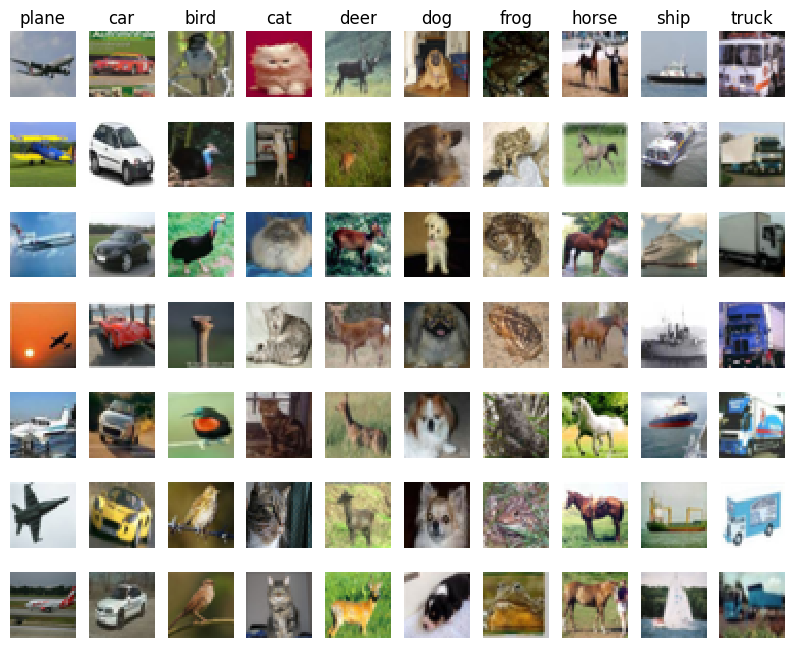

In [4]:

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


In [7]:

# print(X_dev)

[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


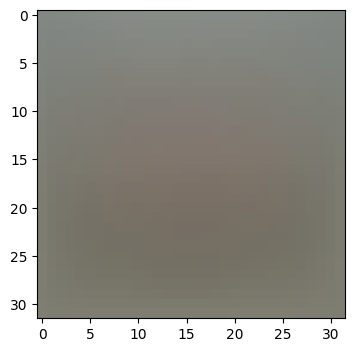

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [9]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
# print(np.ones(5))
# print(np.ones((1, 5)))
# print(np.ones((5, 1)))

In [11]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])  # adds another column of 1's
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs682/classifiers/linear_svm.py**.

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [12]:
# len((np.random.randn(3073, 10) * 0.0001)[0])

In [13]:
# Evaluate the naive implementation of the loss we provided for you:
from cs682.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
# 3073 columns and each has 10 randomly assigned Weights
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.448773


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [14]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs682.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -6.603712 analytic: -6.574109, relative error: 2.246373e-03
numerical: -7.281639 analytic: -7.281639, relative error: 9.732756e-12
numerical: 34.381179 analytic: 34.381179, relative error: 1.050722e-11
numerical: -3.784046 analytic: -3.784046, relative error: 8.005416e-11
numerical: 8.999520 analytic: 8.999520, relative error: 5.809708e-11
numerical: -35.320526 analytic: -35.320526, relative error: 3.184218e-12
numerical: 7.868510 analytic: 7.868510, relative error: 4.685120e-11
numerical: -29.216401 analytic: -29.241883, relative error: 4.359017e-04
numerical: 37.263860 analytic: 37.263860, relative error: 6.526077e-12
numerical: 4.491533 analytic: 4.491533, relative error: 9.584704e-12
numerical: 4.196014 analytic: 4.196014, relative error: 1.710585e-11
numerical: -15.364946 analytic: -15.364946, relative error: 4.300093e-12
numerical: -15.877034 analytic: -15.910126, relative error: 1.041056e-03
numerical: -1.670620 analytic: -1.670620, relative error: 5.273448e-11
numeri

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** An issue can arise in calculating the loss that's fed into the gradient. In the Analytical Evaluation of the gradient, the loss is added if the score of the correct class is not greater than another class by a margin of delta. This is determined with the maximum function: max(0, S_j - S_y_i + delta). Issues can arise when the two values in the max function are the same and the gradient can have issues in being calculated. It is not a major reason for concern because if the two values in the max function are the same, then no loss needs to be added, and thus the gradient calculation is unaffected. Considering this, a function can be implemented to skip, or add nothing to the loss to safeguard against code-breaks and compilation issues. Thus, this issue can result in the gradcheck not matching exactly, but the issue should be negligible.

A simple example of where gradient check could fail is the value of h in Numerical Evaluation. The value is set at a rigid amount, whereas Analytical Evaluation is precise. This shortcoming in Numerical Evaluation can result in discrepancies and cause gradient check to fail.

If the margin of delta is increased, then there will be more positive outputs from the max function. This roots back to what was determined in the first paragraph. Because there will be more positive values in the max(0, _) function, there will be less instances in which both values in the max function are the same, thus resulting in less issues in the loss function calculation and thus less frequency of a dimension in gradcheck not matching exactly.

In [15]:
# import numpy as np
# np.arange(500)
# # range(500)

In [16]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.448773e+00 computed in 0.207517s
Vectorized loss: 9.448773e+00 computed in 0.029381s
difference: 0.000000


In [17]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.203292s
Vectorized loss and gradient: computed in 0.022919s
difference: 0.000000


In [18]:
# svm_loss_vectorized(W, X_dev, y_dev, 0.000005)

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [19]:
# apparently loss should be going down to five ??

In [20]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs682.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 785.296231
iteration 100 / 1500: loss 286.574817
iteration 200 / 1500: loss 108.088728
iteration 300 / 1500: loss 42.563945
iteration 400 / 1500: loss 18.952117
iteration 500 / 1500: loss 10.983784
iteration 600 / 1500: loss 7.249218
iteration 700 / 1500: loss 5.982865
iteration 800 / 1500: loss 5.640610
iteration 900 / 1500: loss 5.071058
iteration 1000 / 1500: loss 4.865692
iteration 1100 / 1500: loss 5.469504
iteration 1200 / 1500: loss 5.791966
iteration 1300 / 1500: loss 5.609868
iteration 1400 / 1500: loss 5.110073
That took 11.914477s


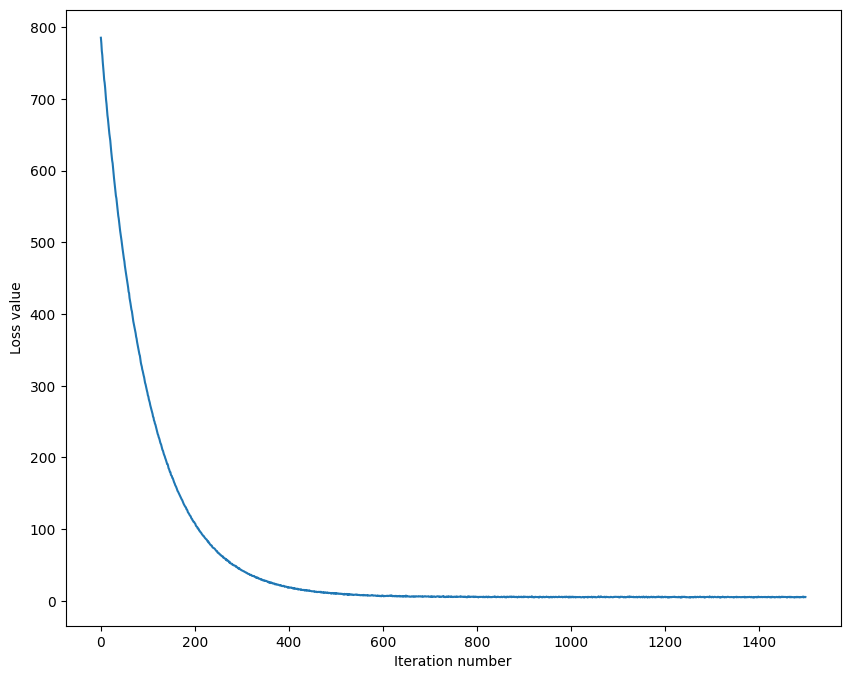

In [21]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [22]:
# print(y_train)  # does y_train also have just 1D class numbers ??

In [23]:
# my accuracies keep getting frozen at these values ??
# Does this means my weights suck ?? But my Analytically Evaluated weights
# and gradients match those of the provided Numerically Evaluated weights
# and gradients

# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370429
validation accuracy: 0.389000


In [24]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.


# learning_rates = [1e-7, 2.5e-6, 5e-5]
# learning_rates = [1e-7, 2.5e-6, 5e-5]
# learning_rates = [1e-8, 1e-7, 5e-5]

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# train SVM model on X_val
for lr in learning_rates:
    for rs in regularization_strengths:

      print("learning rate:", lr, "reg strength", rs)

      svm_tune = LinearSVM()
      loss_hist = svm_tune.train(X_train, y_train, learning_rate=lr, reg=rs,
                            num_iters=1500, verbose=True)

      # evaluate the performance on both the training and validation set
      y_train_pred_tune = svm_tune.predict(X_train)
      train_tune_acc = np.mean(y_train == y_train_pred_tune)
      print('training accuracy: %f' % (train_tune_acc, ))

      y_val_pred_tune = svm_tune.predict(X_val)
      val_tune_acc = np.mean(y_val == y_val_pred_tune)
      print('validation accuracy: %f' % (val_tune_acc, ))

      results[(lr, rs)] = (train_tune_acc, val_tune_acc)

      # if validation accuracy value is greater than the current stored one
      # (best_val), then store it and the current SVM object
      if best_val <= val_tune_acc:
          best_val = val_tune_acc
          best_svm = svm_tune

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning rate: 1e-07 reg strength 25000.0
iteration 0 / 1500: loss 787.989125
iteration 100 / 1500: loss 287.141714
iteration 200 / 1500: loss 108.480249
iteration 300 / 1500: loss 42.569425
iteration 400 / 1500: loss 18.600972
iteration 500 / 1500: loss 10.382949
iteration 600 / 1500: loss 6.838607
iteration 700 / 1500: loss 6.085458
iteration 800 / 1500: loss 5.375543
iteration 900 / 1500: loss 5.550540
iteration 1000 / 1500: loss 5.858720
iteration 1100 / 1500: loss 5.279834
iteration 1200 / 1500: loss 4.969959
iteration 1300 / 1500: loss 5.167940
iteration 1400 / 1500: loss 5.173333
training accuracy: 0.373041
validation accuracy: 0.382000
learning rate: 1e-07 reg strength 50000.0
iteration 0 / 1500: loss 1543.267218
iteration 100 / 1500: loss 208.249765
iteration 200 / 1500: loss 32.560616
iteration 300 / 1500: loss 8.560637
iteration 400 / 1500: loss 5.853584
iteration 500 / 1500: loss 5.852630
iteration 600 / 1500: loss 5.834189
iteration 700 / 1500: loss 5.839969
iteration 800 

/content/drive/MyDrive/cs682/assignment1/cs682/classifiers/linear_svm.py:166: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/MyDrive/cs682/assignment1/cs682/classifiers/linear_svm.py:166: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
training accuracy: 0.055653
validation accuracy: 0.066000
learning rate: 5e-05 reg strength 50000.0
iteration 0 / 1500: loss 1558.859431
iteration 100 / 1500: loss 4208527446800260326444825648252925903971477598011641795360765823728353196168268866517143305228000996718765864600612043227136.000000
iteration 200 / 1500: loss 10867469486425380903260028231993564370603079557028706381269796254986531581999114295663129488045323444373572361488078284570632604513096017546538629642478509938213419317508100871587297480607298860830741673828726272508653175992432052890301823451136.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


/content/drive/MyDrive/cs682/assignment1/cs682/classifiers/linear_svm.py:188: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.373041 val accuracy: 0.382000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.358347 val accuracy: 0.368000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.055653 val accuracy: 0.066000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.382000


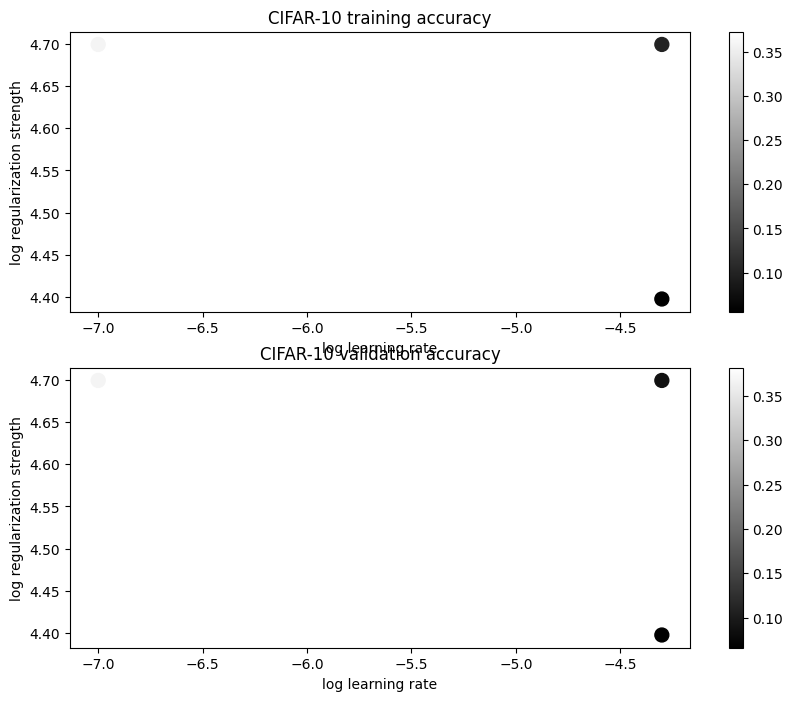

In [25]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [26]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.371000


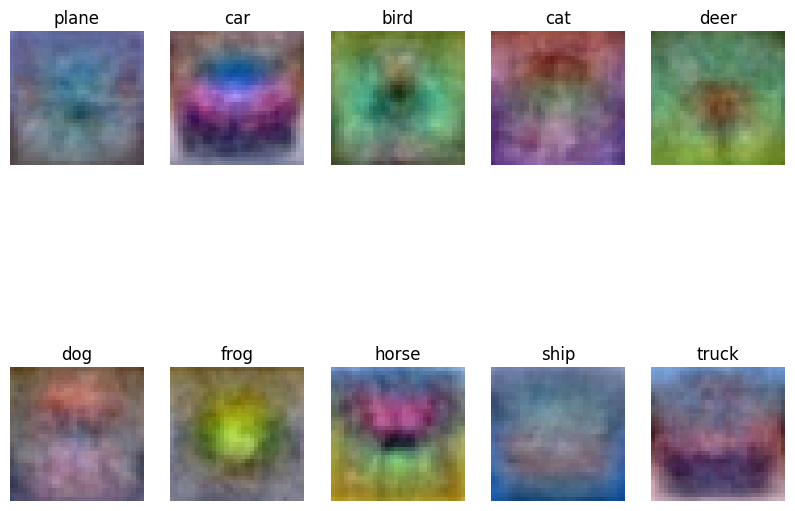

In [27]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** The visualized SVM weights look like an amalgamation of the actual images themselves ! You can actually see that in the case of the horse, the weights are imaged to be almost a two-headed horse. This is reflecting the fact that the weights are considering images of horses from both directions. There is also the green grass, blue sky, and the general brownness of a horse's fur. The car weight image also follows a similar suit. It appears to be the front of a car from different angles. The windshield is curved as if it's going in both directions. There also appears to be a lot of red cars in the dataset because the car weight is averaged to a red pixel. Really really neat stuff ! Generally, each weight image appears to be an average of all the images – dog looks like a dog, frog looks like a frog, deer appears to be a dear etc.